## Vision Tutorial

Based on: http://dev.fast.ai/tutorial.transfer_learning

In [114]:
import numpy as np

from functools import partial

from fastai2.optimizer import Adam
from fastai2.metrics import error_rate
from fastai2.callback.schedule import fit_one_cycle

from fastai2.vision.core import imagenet_stats, PILMask
from fastai2.vision.data import ImageBlock
from fastai2.vision.augment import RandomResizedCrop
from fastai2.vision.augment import aug_transforms
from fastai2.vision.learner import cnn_learner, cnn_config, unet_learner, unet_config

from fastai2.data.block import DataBlock, CategoryBlock
from fastai2.data.transforms import get_image_files, RandomSplitter, RegexLabeller, Normalize
from fastai2.data.external import URLs, untar_data

from torchvision.models import resnet34

In [82]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

In [83]:
image_path = '/home/josh/.fastai/data/oxford-iiit-pet/images'

In [84]:
dbunch = pets.databunch(image_path, item_tfms=RandomResizedCrop(460, min_scale=0.75), bs=32,
                        batch_tfms=[*aug_transforms(size=299, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [85]:
len(dbunch.train_ds.items)

5912

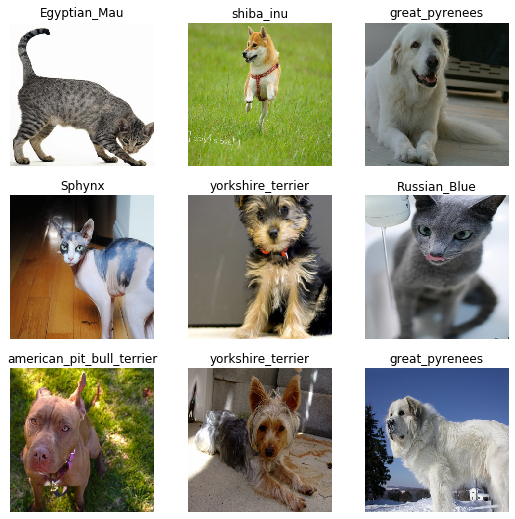

In [86]:
dbunch.show_batch(max_n=9)

In [92]:
opt_func = partial(Adam, lr=slice(3e-3), wd=0.01, eps=1e-8)
learn = cnn_learner(dbunch, resnet34, opt_func=opt_func, metrics=error_rate, config=cnn_config(ps=0.33))

In [96]:
learn.fit_one_cycle(1)

(#5) [0,0.5919883251190186,0.24513790011405945,0.07645466178655624,'00:30']


In [97]:
learn.unfreeze()
# learn.fit_one_cycle(4, slice(1e-5, 1e-3))
learn.fit_one_cycle(1, slice(1e-5, 1e-3))

(#5) [0,0.36801037192344666,0.21127571165561676,0.06698239594697952,'00:40']


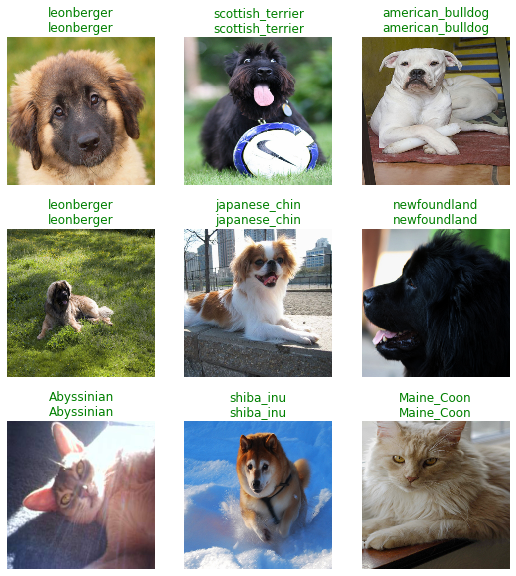

In [98]:
learn.show_results(max_n=9)

## Segmentation

In [100]:
path = untar_data(URLs.CAMVID_TINY)

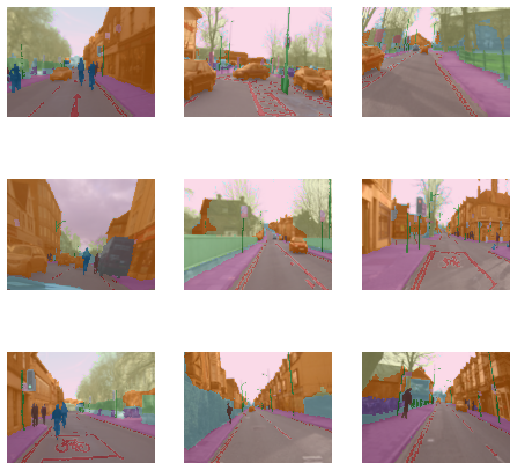

In [106]:
camvid = DataBlock(blocks=(ImageBlock, ImageBlock(cls=PILMask)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}')

dbunch = camvid.databunch(path/"images", batch_tfms=aug_transforms())
dbunch.show_batch(max_n=9, vmin=1, vmax=30)

In [110]:
dbunch.vocab = np.loadtxt(untar_data(URLs.CAMVID_TINY)/'codes.txt', dtype=str)

In [121]:
learn = unet_learner(dbunch, resnet34, config=unet_config())
learn.fit_one_cycle(10, 1e-3)

(#4) [0,4.11018705368042,3.5115768909454346,'00:01']
(#4) [1,4.073780536651611,3.5368542671203613,'00:01']
(#4) [2,3.873849630355835,3.1950018405914307,'00:01']
(#4) [3,3.663357734680176,3.74755859375,'00:01']
(#4) [4,3.4872114658355713,4.330811023712158,'00:01']
(#4) [5,3.3395731449127197,4.030058860778809,'00:01']
(#4) [6,3.21600341796875,3.7660000324249268,'00:01']
(#4) [7,3.114184617996216,3.295727252960205,'00:01']
(#4) [8,3.028120279312134,2.8697402477264404,'00:01']
(#4) [9,2.955275535583496,2.601191282272339,'00:01']


In [122]:
learn.predict(dbunch.train_ds.items[0]);

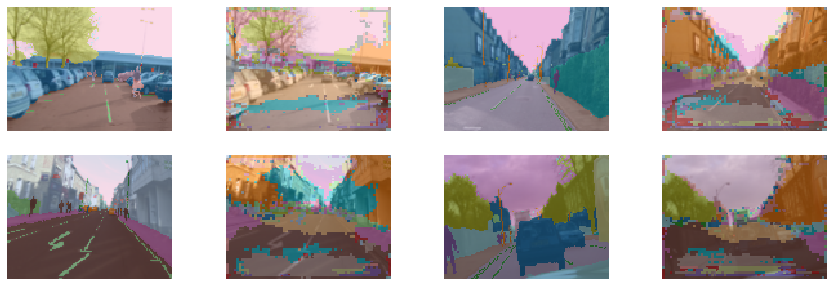

In [123]:
learn.show_results(max_n=4, figsize=(15,5))